In [1]:
!unzip data.zip

Archive:  data.zip
   creating: Mobile Price Prediction/
  inflating: Mobile Price Prediction/test.csv  
  inflating: Mobile Price Prediction/train.csv  


In [2]:
!pip install torch-snippets torchsummary -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.3/110.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.0/221.0 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 116.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.4 MB/s eta 0:00:00


In [3]:
import warnings
warnings.filterwarnings('ignore')

import copy
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # (전처리 보강을 위해 추가)
from sklearn.metrics import classification_report, confusion_matrix # (평가 보강을 위해 추가)

import torch
from torch import nn, optim
import torch.nn.functional as F # (모델 정의에 사용됨)
from torch_snippets import *
from torch.utils.data import DataLoader, Dataset, TensorDataset # (TensorDataset 추가)
from torchsummary import summary

print("\nLibraries installed and imported.")


Libraries installed and imported.


In [ ]:
#@title 2. 디바이스 설정 및 파라미터 정의

sns.set_theme()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('torch version:',torch.__version__)
print('device:', device)

# --- 원본 노트북의 파라미터 ---
data_path = '/content/Mobile Price Prediction' # 데이터 폴더 경로

train_data_path = os.path.join(data_path, 'train.csv')
test_data_path = os.path.join(data_path, 'test.csv')
print('\ntrain_data_path:', train_data_path)
print('test_data_path:', test_data_path)

batch_size = 64
validation_split = 0.2

# Model (원본의 h1, h2는 모델 정의 시 직접 사용)
in_features = 3
h1 = 8
h2 = 9

# Training
epochs = 200
learning_rate = 0.001

torch version: 2.8.0+cu126
device: cuda

train_data_path: /content/Mobile Price Prediction/train.csv
test_data_path: /content/Mobile Price Prediction/test.csv


In [5]:
#@title 3. 데이터 로드 및 피처 엔지니어링

try:
    df = pd.read_csv(train_data_path)
    print("Training data loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: File not found at {train_data_path}. Please check the path.")
    df = None

if df is not None:
    # 원본 코드의 피처 엔지니어링: 해상도(Res) 피처 생성
    df['Res'] = df['px_height'] * df['px_width']

    # 원본 코드의 피처 선택: ram, battery_power, Res 3개만 사용
    # (이 선택의 타당성은 아래 EDA에서 확인합니다.)
    X = df[['ram','battery_power','Res']]
    y = df['price_range']

    print(f"Data shapes -> X: {X.shape}, y: {y.shape}")

Training data loaded successfully.
Data shapes -> X: (2000, 3), y: (2000,)


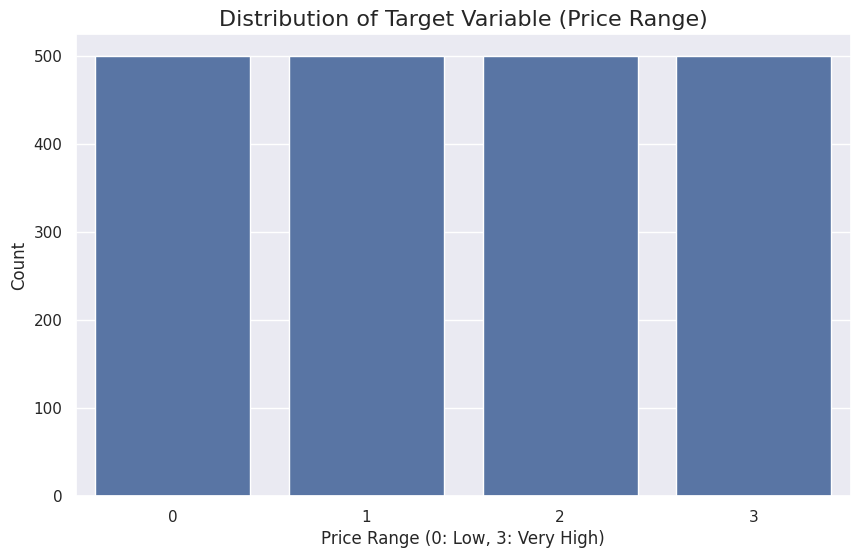

Analysis: The dataset is perfectly balanced across the four price ranges.


In [6]:
#@title 4. [EDA 보강] Target(Price Range) 분포 확인 (영문 Plot)

if df is not None:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=y)
    plt.title('Distribution of Target Variable (Price Range)', fontsize=16)
    plt.xlabel('Price Range (0: Low, 3: Very High)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.show()

    print("Analysis: The dataset is perfectly balanced across the four price ranges.")


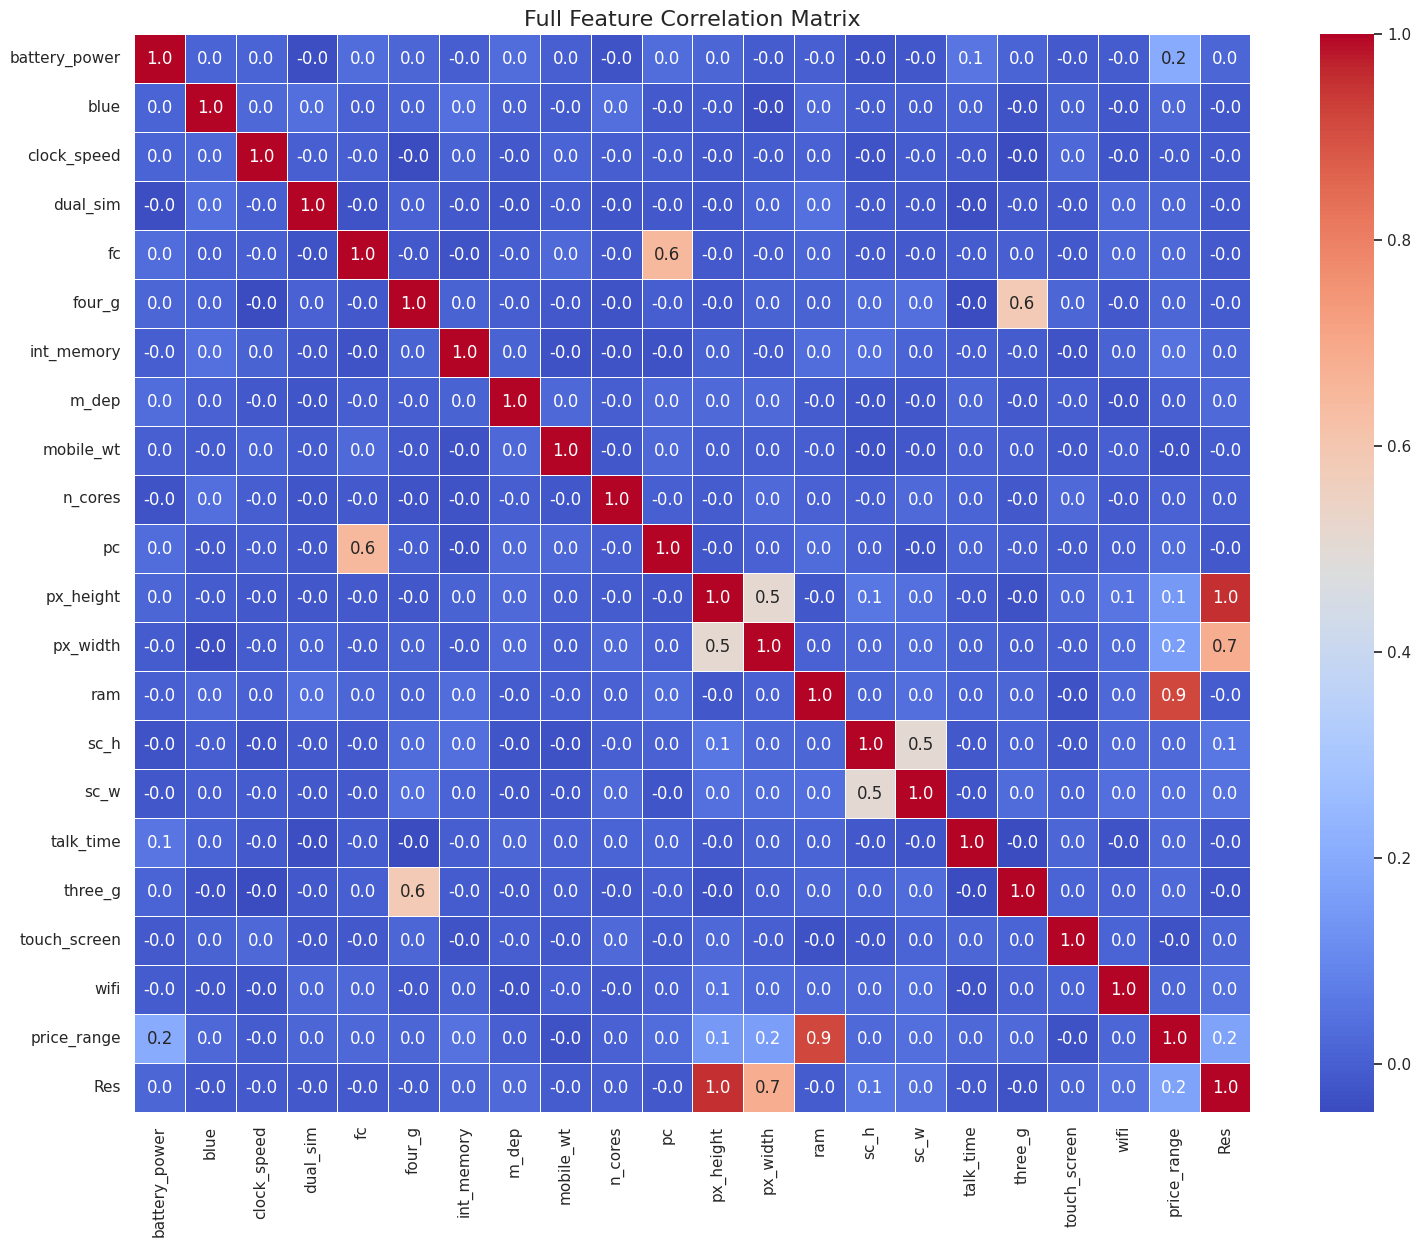


Analysis: 'ram' has the strongest correlation (0.9) with 'price_range'.
'battery_power' (0.2) and the engineered 'Res' (0.2) also show some positive correlation.
This justifies the original author's choice to focus on these three features.


In [7]:
#@title 5. [EDA 보강] 전체 피처 상관관계 (Heatmap - 영문)

if df is not None:
    plt.figure(figsize=(18, 14))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.5)
    plt.title('Full Feature Correlation Matrix', fontsize=16)
    plt.show()

    print("\nAnalysis: 'ram' has the strongest correlation (0.9) with 'price_range'.")
    print("'battery_power' (0.2) and the engineered 'Res' (0.2) also show some positive correlation.")
    print("This justifies the original author's choice to focus on these three features.")


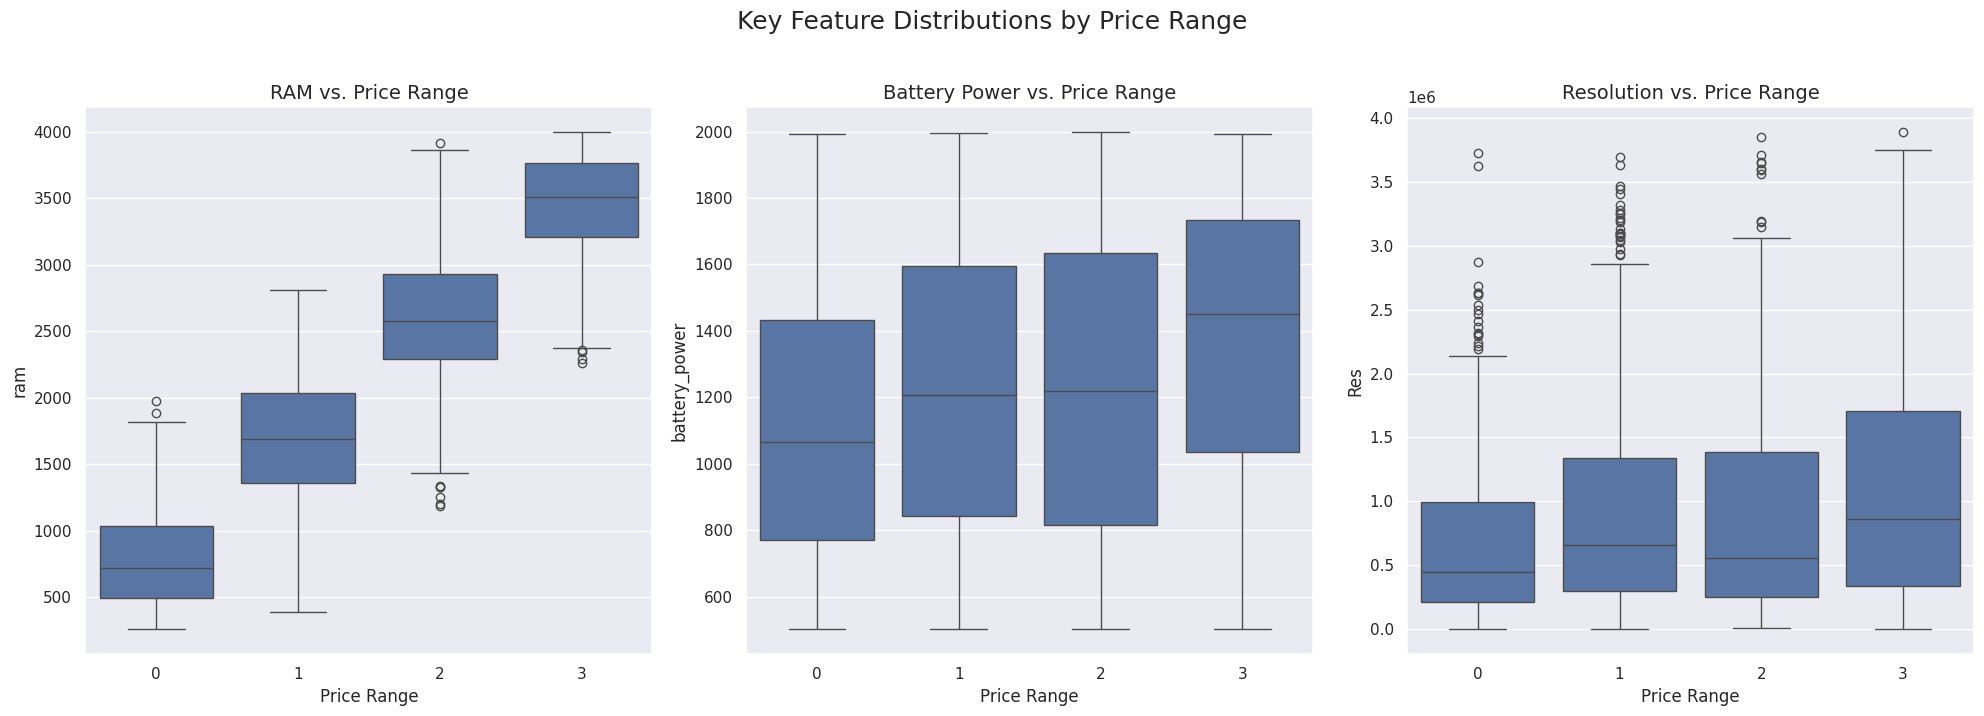

In [8]:
#@title 6. [EDA 보강] 주요 피처 vs 가격 범위 (Box Plots - 영문)

if df is not None:
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    fig.suptitle('Key Feature Distributions by Price Range', fontsize=18, y=1.02)

    # 1. RAM
    sns.boxplot(data=df, x='price_range', y='ram', ax=axes[0])
    axes[0].set_title('RAM vs. Price Range', fontsize=14)
    axes[0].set_xlabel('Price Range', fontsize=12)

    # 2. Battery Power
    sns.boxplot(data=df, x='price_range', y='battery_power', ax=axes[1])
    axes[1].set_title('Battery Power vs. Price Range', fontsize=14)
    axes[1].set_xlabel('Price Range', fontsize=12)

    # 3. Resolution (Res)
    sns.boxplot(data=df, x='price_range', y='Res', ax=axes[2])
    axes[2].set_title('Resolution vs. Price Range', fontsize=14)
    axes[2].set_xlabel('Price Range', fontsize=12)

    plt.tight_layout()
    plt.show()

In [ ]:
#@title 7. 데이터 전처리 및 Tensor 변환 (원본 기반 + Scaling 보강)

if df is not None:
    # 1. 원본과 동일하게 Numpy 배열로 변환
    X_np = X.to_numpy()
    y_np = y.to_numpy().reshape(-1,1)

    # 2. Train / Valid 데이터 분리 (원본 로직 유지)
    X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(
        X_np, y_np, test_size=validation_split, shuffle=True, random_state=42, stratify=y_np
    )

    # 훈련 데이터 기준으로 학습(fit)하고, 검증 데이터는 변환(transform)만 적용
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_valid_scaled = scaler.transform(X_valid_raw)

    print(f"Train/Valid split -> Train: {len(X_train_scaled)}, Valid: {len(X_valid_scaled)}")

    # 4. PyTorch Tensor로 변환 (원본 로직 유지)
    X_train = torch.FloatTensor(X_train_scaled).to(device)
    y_train = torch.LongTensor(y_train).reshape(-1).to(device)
    X_valid = torch.FloatTensor(X_valid_scaled).to(device)
    y_valid = torch.LongTensor(y_valid).reshape(-1).to(device)

    print(f"\nTensor shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}")


Train/Valid split -> Train: 1600, Valid: 400

Tensor shapes -> X_train: torch.Size([1600, 3]), y_train: torch.Size([1600])


In [ ]:
#@title 8. PyTorch 모델 및 학습 함수 정의

class FullyConnectedMobilePricePredictor(nn.Module):
    def __init__(self, in_features, h1, h2, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)
        self.fc2 = nn.BatchNorm1d(h1)
        self.fc3 = nn.Linear(h1,h2)
        self.fc4 = nn.BatchNorm1d(h2)
        self.out = nn.Linear(h2,out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.out(x)
        return x

# --- 원본 노트북의 학습/검증 함수 ---
def train(X_train, y_train, model, optimizer, loss_fn):
    model.train()
    outputs = model.forward(X_train)
    loss = loss_fn(outputs, y_train)
    preds = outputs.argmax(-1)
    acc = (sum(preds==y_train) / len(y_train))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item() # .item()으로 숫자 값만 반환

@torch.no_grad()
def validate(X_valid, y_valid, model, loss_fn):
    model.eval()
    outputs = model(X_valid)
    loss = loss_fn(outputs, y_valid)
    preds = outputs.argmax(-1)
    acc = (sum(preds==y_valid) / len(y_valid))
    return loss.item(), acc.item()

print("PyTorch model and train/validation functions are defined.")

PyTorch model and train/validation functions are defined.


In [ ]:
#@title 9. 모델 학습 실행

if df is not None:
    # 원본의 y.value_counts() 로직을 사용하여 클래스 수 정의
    num_class = len(y.value_counts())

    # 모델, 손실함수, 옵티마이저 초기화
    fully_connected_mobile_price_predictor = FullyConnectedMobilePricePredictor(in_features, h1, h2, num_class).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(fully_connected_mobile_price_predictor.parameters(), lr=learning_rate)

    # torch_snippets Report 객체로 학습 과정 로깅
    log = Report(epochs)

    print("--- Model Architecture ---")
    summary(fully_connected_mobile_price_predictor, (in_features,));

    print("\nStarting model training...")

    for epoch in range(epochs):
        train_loss, train_acc = train(X_train, y_train, fully_connected_mobile_price_predictor,
                                      optimizer, loss_fn)
        val_loss, val_acc = validate(X_valid, y_valid, fully_connected_mobile_price_predictor, loss_fn)

        # 로그 기록
        log.record(epoch+1, train_loss=train_loss, train_acc=train_acc,
                   val_loss=val_loss, val_acc=val_acc, end='\r')

    print("\nModel training finished.")
else:
    log = None # 데이터 로드 실패 시 log 객체 초기화

--- Model Architecture ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 8]              32
       BatchNorm1d-2                    [-1, 8]              16
            Linear-3                    [-1, 9]              81
       BatchNorm1d-4                    [-1, 9]              18
            Linear-5                    [-1, 4]              40
Total params: 187
Trainable params: 187
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------

Starting model training...
EPOCH: 200.000  train_loss: 0.721  train_acc: 0.709  val_loss: 0.700  val_acc: 0.730  (6.06s - 0.00s remaining)
Model training finished.



Plotting training history...


100%|██████████| 301/301 [00:00<00:00, 22477.75it/s]


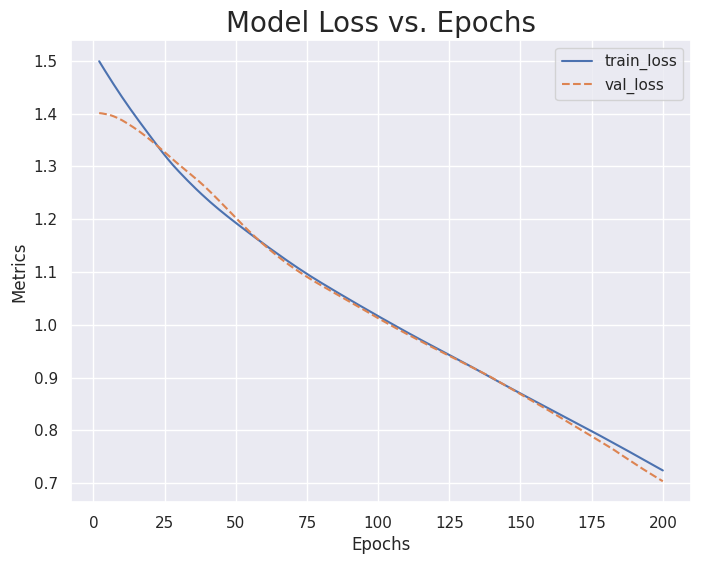

100%|██████████| 301/301 [00:00<00:00, 17114.50it/s]


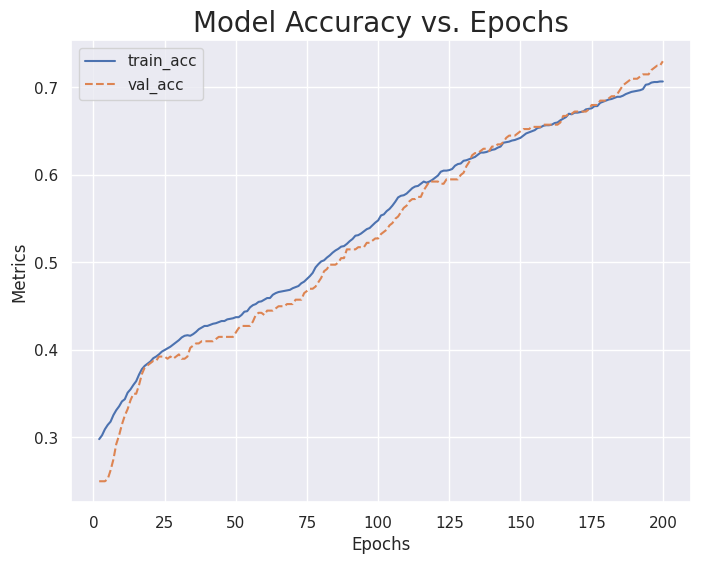

In [14]:
#@title 10. 결과 분석: 학습 곡선 시각화 (원본 Plot 유지)

if log:
    print("\nPlotting training history...")
    log.plot_epochs(['train_loss', 'val_loss'], title="Model Loss vs. Epochs", ylabel="Cross Entropy Loss")
    log.plot_epochs(['train_acc', 'val_acc'], title="Model Accuracy vs. Epochs", ylabel="Accuracy")
else:
    print("Training log not available.")



--- Final Model Evaluation on Validation Set ---

[Classification Report (English)]
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       100
           1       0.85      0.28      0.42       100
           2       0.55      0.68      0.61       100
           3       0.77      0.99      0.86       100

    accuracy                           0.73       400
   macro avg       0.75      0.73      0.70       400
weighted avg       0.75      0.73      0.70       400


Plotting Confusion Matrix...


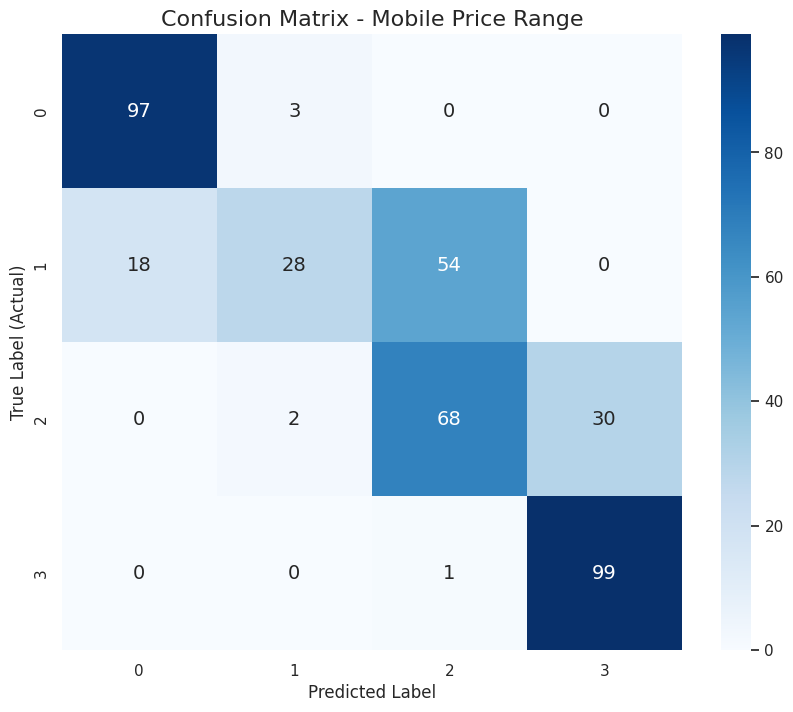

In [15]:
#@title 11. [결과 분석 보강] 최종 평가 (리포트 및 혼동 행렬 - 영문)

if log:
    print("\n--- Final Model Evaluation on Validation Set ---")

    # 1. 검증 데이터셋 전체에 대한 최종 예측
    fully_connected_mobile_price_predictor.eval()
    with torch.no_grad():
        y_pred_tensor = fully_connected_mobile_price_predictor(X_valid)
        y_pred = y_pred_tensor.argmax(-1).cpu().numpy()
        y_true = y_valid.cpu().numpy()

    # 2. 분류 리포트 (Classification Report)
    class_names = [str(i) for i in range(num_class)]
    print("\n[Classification Report (English)]")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # 3. 혼동 행렬 (Confusion Matrix) 시각화
    print("\nPlotting Confusion Matrix...")
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                annot_kws={"size": 14})
    plt.title('Confusion Matrix - Mobile Price Range', fontsize=16)
    plt.ylabel('True Label (Actual)', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()